# Intro to Dask


### What is dask?
A package in python that does __distributed programming__. It is useful as a higher level interface for doing complicated distributed programming in an intuitive way. 

Distributed programming is useful when you don't have the ability to read things entirely into memory, and so of great use when we have large datasets.

It is similar in function to __Apache Spark__ or the `pyspark` package for Python.

Before we learned how to manually parallelize operations, but in `dask` it will more or less be done automatically. A great advantage is that the interface mimics `pandas` and `numpy` and so can be used easily.



### Delayed tasks

One of the first handy things that `dask` can do is do functions in a batch using the `delayed` framework

Before doing that, we need to initiate a client for us to work with:

In [1]:
from dask.distributed import Client, progress
client = Client(threads_per_worker=2, n_workers=4)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 31.67 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:51745,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 31.67 GiB
Comm: tcp://127.0.0.1:51767,Total threads: 2
Dashboard: http://127.0.0.1:51774/status,Memory: 7.92 GiB
Nanny: tcp://127.0.0.1:51748,


Say that we wanted to run this sequence of functions:

In [2]:
import time
import random
import pandas as pd

def inc(x):
    time.sleep(1)
    return x + 1

def dec(x):
    time.sleep(1)
    return x - 1

def add(x, y):
    time.sleep(1)
    return x + y

In [3]:
%%time
x = inc(1)
y = dec(2)
z = add(x, y)
z 

CPU times: total: 125 ms
Wall time: 3.01 s


3

Notice that the function `inc` and the function `dec` could be called independently! You only need to add them at the end.

The power of the dask delayed framework is its ability to lay out the best way to execute it before it needs to be done:

In [4]:
import dask
inc_d = dask.delayed(inc)
dec_d = dask.delayed(dec)
add_d = dask.delayed(add)

In [5]:
x = inc_d(1)
y = dec_d(2)
z = add_d(x, y)
z

Delayed('add-39011c07-6041-4d76-8f2b-86f23f2de45c')

That didn't take any time at all. Why? Because it hasn't run it yet.

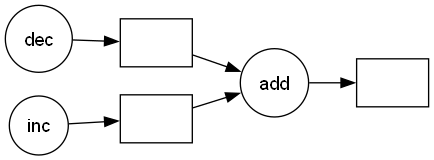

In [6]:
z.visualize(rankdir='LR')

In [7]:
%%time
z.compute()

CPU times: total: 250 ms
Wall time: 2.03 s


3

In [8]:
%%time
zs_s = []
for i in range(20):
    x = inc(i)
    y = dec(x)
    z = add(x, y)
    zs_s.append(z)

CPU times: total: 1.38 s
Wall time: 1min


In [9]:
zs_f = []
for i in range(20):
    x = inc_d(i)
    y = dec_d(x)
    z = add_d(x, y)
    zs_f.append(z)

In [10]:
%%time
zs = dask.compute(*zs_f)

CPU times: total: 1.05 s
Wall time: 8.66 s


Using Dask makes parallelizing quite easy!

## Distributed Programming

### Dask Dataframe

One of the most useful implementations of `dask` is using the `dataframe` API, which mimicks an actual DataFrame.

For this example and your homework, we will look at a bilateral trade flows dataset called BACI. We will be analyzing the years 2012-2018.

In [7]:
trade_dir = "C:/Users/jhtchns2/Box/ACE_592_SAE/Homework_3/BACI_HS12_V202201/"

In [8]:
df18 = pd.read_csv(trade_dir + "BACI_HS12_Y2018_V202201.csv",nrows=100)
df18

,t,i,j,k,v,q
0,2018,4,24,845420,114.415,26.000
1,2018,4,24,848180,2.631,0.007
2,2018,4,31,80211,0.333,0.042
3,2018,4,31,80212,1.982,0.196
4,2018,4,31,80620,0.174,0.042
...,...,...,...,...,...,...
95,2018,4,40,190590,0.039,0.022
96,2018,4,40,200811,0.011,0.003
97,2018,4,40,200899,0.020,0.013
98,2018,4,40,300590,2.036,0.024


Each row represents the trade flows from country $i$ to country $j$ for product $k$ in time $t$ in terms of either value or quantity.

Since we have 8 million rows of data in one year, this means we can expect about 56 million rows in the final dataset. This will be hard to work with all in memory at the same time!

Some options:
1. Chunk all our operations and run on each file.
2. Use the `dask` `dataframe` API framework.

We got a sense for how to use option 1, so now let's go to option 2.

In [9]:
import dask.dataframe as dd

In [10]:
df = dd.read_csv(trade_dir + "BACI_HS12_Y*.csv")
df

,t,i,j,k,v,q
npartitions=66,,,,,,
,int64,int64,int64,int64,float64,float64
,...,...,...,...,...,...
...,...,...,...,...,...,...
,...,...,...,...,...,...
,...,...,...,...,...,...


Notice I used read_csv to find __all__ the files in that directory and read them into one structure.

In [11]:
import glob
glob.glob(trade_dir + "BACI_HS12_Y*.csv")

['C:/Users/jhtchns2/Box/ACE_592_SAE/Homework_3/BACI_HS12_V202201\\BACI_HS12_Y2012_V202201.csv',
 'C:/Users/jhtchns2/Box/ACE_592_SAE/Homework_3/BACI_HS12_V202201\\BACI_HS12_Y2013_V202201.csv',
 'C:/Users/jhtchns2/Box/ACE_592_SAE/Homework_3/BACI_HS12_V202201\\BACI_HS12_Y2014_V202201.csv',
 'C:/Users/jhtchns2/Box/ACE_592_SAE/Homework_3/BACI_HS12_V202201\\BACI_HS12_Y2015_V202201.csv',
 'C:/Users/jhtchns2/Box/ACE_592_SAE/Homework_3/BACI_HS12_V202201\\BACI_HS12_Y2016_V202201.csv',
 'C:/Users/jhtchns2/Box/ACE_592_SAE/Homework_3/BACI_HS12_V202201\\BACI_HS12_Y2017_V202201.csv',
 'C:/Users/jhtchns2/Box/ACE_592_SAE/Homework_3/BACI_HS12_V202201\\BACI_HS12_Y2018_V202201.csv',
 'C:/Users/jhtchns2/Box/ACE_592_SAE/Homework_3/BACI_HS12_V202201\\BACI_HS12_Y2019_V202201.csv',
 'C:/Users/jhtchns2/Box/ACE_592_SAE/Homework_3/BACI_HS12_V202201\\BACI_HS12_Y2020_V202201.csv']

But why did it give me 66 partitions if I only have 7 csv files?

In [ ]:
df.map_partitions(len).compute().plot(kind='bar')

So all the partitions are about the same number of obs.

In [ ]:
def mem_usage(x):
    return x.memory_usage().sum()

df.map_partitions(mem_usage).compute().plot(kind='bar')

And about the same memory usage (around 60 mb per partition).

__Rule of thumb__: partitions should be around 100 mb each.

Here `dask` tries to do it automatically.

My strategic use of the `map_partitions` will map a function to each partition.

All 7 of these files now exist as "partitions" in this dataframe object. Now when we do an operation it will be "distributed" to all the partitions.

So now the advantage of this framework is that we can run operations on all the data but `dask` does the chunking and parallelizing for us!

__Advantage__: no need to do everything in memory!

__Disadvantage__: will be slower than in-memory.

Thus only an advantage when your data will not fit in memory.

#### How it works:
- Run as many operations as you need to on the symbolic dataframe object.
- Call "compute" when you actually need to see the results.

In [23]:
df

,t,i,j,k,v,q
npartitions=66,,,,,,
,int64,int64,int64,int64,float64,float64
,...,...,...,...,...,...
...,...,...,...,...,...,...
,...,...,...,...,...,...
,...,...,...,...,...,...


Note that the read_csv function has "1 graph layer."

What happens if we add an operation?

In [24]:
df.loc[df.t==2018]

,t,i,j,k,v,q
npartitions=66,,,,,,
,int64,int64,int64,int64,float64,float64
,...,...,...,...,...,...
...,...,...,...,...,...,...
,...,...,...,...,...,...
,...,...,...,...,...,...


So it added a couple more tasks after I did a slicing.

Let's add one more:

In [25]:
df.loc[df.t==2018].groupby("k")['v'].mean()

Dask Series Structure:
npartitions=1
    float64
        ...
Name: v, dtype: float64
Dask Name: truediv, 10 graph layers

So taking a group average for the year 2018 takes 10 graph layers.

When we actually need the results, we can run `compute`:

In [26]:
df.loc[df.t==2018].groupby("k")['v'].mean().compute()

k
10121     1524.747365
10129     1219.522900
10130       50.608992
10190       94.922452
10221     2119.432946
             ...     
970200     316.031400
970300    1158.938646
970400      90.111293
970500     469.196650
970600    1600.675885
Name: v, Length: 5199, dtype: float64

So now we can calculate a useful summary statistic of the entire dataset without having to read the entire dataset!

#### Persisting memory

In case you want one set of results in memory, you can use the `persist` function to put your results in memory.

Suppose I want to persist the product with the code 10121:

In [27]:
df10121 = df[df.k==10121].persist()

In [28]:
df10121

,t,i,j,k,v,q
npartitions=66,,,,,,
,int64,int64,int64,int64,float64,float64
,...,...,...,...,...,...
...,...,...,...,...,...,...
,...,...,...,...,...,...
,...,...,...,...,...,...


Now it will apply all these changes in the background so we can keep working. 
 
Notice that it's still not a real "dataframe" yet. This is because its keeping the results distributed across the nodes. We can keep calling more functions on this flow and when it's done it will finish much quicker.

The downside of this is that it has transferred some of this (but not all of it) into the distributed RAM.

The upside here is that it can be called very quickly:

In [29]:
df10121.compute()

,t,i,j,k,v,q
12599,2012,12,251,10121,71.698,0.500
17215,2012,20,251,10121,2.314,1.400
27980,2012,31,842,10121,45.200,3.569
28796,2012,32,36,10121,708.296,0.500
29346,2012,32,40,10121,10.090,0.400
...,...,...,...,...,...,...
10526681,2020,858,842,10121,50.600,0.500
10527439,2020,860,4,10121,1.500,0.477
10532385,2020,860,417,10121,1.433,0.410
10548361,2020,894,404,10121,5.993,4.500


So what is the difference between `persist` and `compute`?

The command `persist` puts it into distributed memory (each worker holding a part of the data) so there are still as many partitions as before. The command `compute` puts it into one python object in your environment. 

__Why we use `persist`__:
- We want to call something into the distributed memory to calculate with `compute`.
- We need it to run asynchronously.
- We need to "set up" a computation that we will eventually compute.
    - Essentially saves us from having to wait a very long time

### Merging

Doing merges can be accomplished the usual way:

In [32]:
products = pd.read_csv(trade_dir + "product_codes_HS12_V202201.csv")
products = products.rename(columns={"code":"k"})

In [33]:
products.head(70)

,k,description
0,10121,"Horses: live, pure-bred breeding animals"
1,10129,"Horses: live, other than pure-bred breeding an..."
2,10130,Asses: live
3,10190,Mules and hinnies: live
4,10221,"Cattle: live, pure-bred breeding animals"
...,...,...
65,20711,Meat and edible offal: of fowls of the species...
66,20712,Meat and edible offal: of fowls of the species...
67,20713,Meat and edible offal: of fowls of the species...
68,20714,Meat and edible offal: of fowls of the species...


In [34]:
df_wdes = df.merge(products)
df_wdes

,t,i,j,k,v,q,description
npartitions=66,,,,,,,
,int64,int64,int64,int64,float64,float64,string
,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...
,...,...,...,...,...,...,...


In [35]:
df_wdes.head()

,t,i,j,k,v,q,description
0,2012,4,8,610469,2.734,0.044,"Trousers, bib and brace overalls, breeches and..."
1,2012,4,124,610469,0.059,0.002,"Trousers, bib and brace overalls, breeches and..."
2,2012,4,276,610469,0.024,0.001,"Trousers, bib and brace overalls, breeches and..."
3,2012,4,757,610469,1.020,0.017,"Trousers, bib and brace overalls, breeches and..."
4,2012,8,124,610469,0.358,0.011,"Trousers, bib and brace overalls, breeches and..."


So now we've merged in a text description of our product codes

In [36]:
trade_dir

'C:/Users/jhtchns2/Box/ACE_592_SAE/Homework_3/BACI_HS12_V202201/'

In [38]:
'C:/Users/jhtchns2/Box/ACE_592_SAE/Homework_3/BACI_HS12_V202201/country_codes_V202201.csv'

'C:/Users/jhtchns2/Box/ACE_592_SAE/Homework_3/BACI_HS12_V202201/country_codes_V202201.csv'

In [39]:
countries = pd.read_csv(trade_dir + "country_codes_V202201.csv",encoding = "ISO-8859-1")
countries = countries.rename(columns={"country_code":"i","country_name_full":"name_i"})
df_wdes = df_wdes.merge(countries[['i','name_i']])

countries = pd.read_csv(trade_dir + "country_codes_V202201.csv",encoding = "ISO-8859-1")
countries = countries.rename(columns={"country_code":"j","country_name_full":"name_j"})
df_wdes = df_wdes.merge(countries[['j','name_j']])

In [40]:
df_wdes.head(10)

,t,i,j,k,v,q,description,name_i,name_j
0,2012,4,8,610469,2.734,0.044,"Trousers, bib and brace overalls, breeches and...",Afghanistan,Albania
1,2012,4,8,630900,0.110,0.082,"Clothing: worn, and other worn articles",Afghanistan,Albania
2,2012,20,8,910211,2.314,0.003,"Wrist-watches: electrically operated, with or ...",Andorra,Albania
3,2012,20,8,960810,0.144,NaN,Pens: ball point,Andorra,Albania
4,2012,20,8,80510,1.457,2.228,"Fruit, edible: oranges, fresh or dried",Andorra,Albania
5,2012,28,8,170490,0.064,0.009,"Sugar confectionery: (excluding chewing gum, i...",Antigua and Barbuda,Albania
6,2012,28,8,80550,3.389,4.517,"Fruit, edible: lemons (Citrus limon, Citrus li...",Antigua and Barbuda,Albania
7,2012,28,8,200811,1.571,0.427,"Nuts: ground-nuts, whether or not containing a...",Antigua and Barbuda,Albania
8,2012,28,8,190531,0.030,0.005,"Food preparations: sweet biscuits, whether or ...",Antigua and Barbuda,Albania
9,2012,28,8,230400,15.601,25.000,Oil-cake and other solid residues: whether or ...,Antigua and Barbuda,Albania


### Which dataframe operations the dask API supports:

__Element by element operations__

In [41]:
df_wdes['avg_price'] = df_wdes['v']/df_wdes['q']

Since its delaying the operations, it won't run until I call `compute`, though notice that it just added a column to this dataset.

In [42]:
df_wdes.head(10)

,t,i,j,k,v,q,description,name_i,name_j,avg_price
0,2012,4,8,610469,2.734,0.044,"Trousers, bib and brace overalls, breeches and...",Afghanistan,Albania,62.136364
1,2012,4,8,630900,0.110,0.082,"Clothing: worn, and other worn articles",Afghanistan,Albania,1.341463
2,2012,20,8,910211,2.314,0.003,"Wrist-watches: electrically operated, with or ...",Andorra,Albania,771.333333
3,2012,20,8,960810,0.144,NaN,Pens: ball point,Andorra,Albania,NaN
4,2012,20,8,80510,1.457,2.228,"Fruit, edible: oranges, fresh or dried",Andorra,Albania,0.653950
5,2012,28,8,170490,0.064,0.009,"Sugar confectionery: (excluding chewing gum, i...",Antigua and Barbuda,Albania,7.111111
6,2012,28,8,80550,3.389,4.517,"Fruit, edible: lemons (Citrus limon, Citrus li...",Antigua and Barbuda,Albania,0.750277
7,2012,28,8,200811,1.571,0.427,"Nuts: ground-nuts, whether or not containing a...",Antigua and Barbuda,Albania,3.679157
8,2012,28,8,190531,0.030,0.005,"Food preparations: sweet biscuits, whether or ...",Antigua and Barbuda,Albania,6.000000
9,2012,28,8,230400,15.601,25.000,Oil-cake and other solid residues: whether or ...,Antigua and Barbuda,Albania,0.624040


__Selecting and slicing__

In [43]:
avg18 = df_wdes.loc[df_wdes.t==2018]['avg_price']

Now call compute to actually make a DataFrame:

In [44]:
ex = avg18.compute()

In [45]:
ex

0             4.400577
1           375.857143
2            33.822069
3            17.344262
4             1.149123
              ...     
1367573      25.013333
1367574       4.453061
1367575     112.579270
1367576    5000.000000
1367577      30.149686
Name: avg_price, Length: 11167345, dtype: float64

__Statistical functions__

In [46]:
avg18.mean().compute()

686.1705899366867

In [47]:
avg18.var().compute()

39495527007.07975

__Typical pandas functionality__

In [48]:
product_counts = df['k'].value_counts().compute()

product_dict = products.set_index("k")['description'].to_dict()

product_counts.index=  pd.Series(product_counts.index).replace(product_dict)

In [49]:
product_counts.head(10)

k
Plastics: other articles n.e.c. in chapter 39                                                                                                                                                                             117540
Iron or steel: articles n.e.c.in heading 7326                                                                                                                                                                             102137
Printed matter: books, brochures, leaflets and similar printed matter n.e.c. in item no. 4901.10 or 4901.91                                                                                                                93445
T-shirts, singlets and other vests: of cotton, knitted or crocheted                                                                                                                                                        92834
Electrical static converters                                                                      

In [50]:
df['q'].nlargest(10).compute()

1336879    7.059573e+08
90921      6.965135e+08
117372     6.924810e+08
108906     6.868821e+08
121201     6.857592e+08
109270     6.776354e+08
113560     6.497960e+08
1431949    6.115246e+08
98624      5.912236e+08
1563422    5.808956e+08
Name: q, dtype: float64

In this case, `nlargest` returns the n largest elements of a column.

It also does groupby in parallel:

In [38]:
country_v_sums = df.groupby("i")['v'].sum().compute()

In [40]:
countries

,j,country_name_abbreviation,name_j,iso_2digit_alpha,iso_3digit_alpha
0,4,Afghanistan,Afghanistan,AF,AFG
1,8,Albania,Albania,AL,ALB
2,12,Algeria,Algeria,DZ,DZA
3,16,American Samoa,American Samoa,AS,ASM
4,20,Andorra,Andorra,AD,AND
...,...,...,...,...,...
222,876,Wallis and Futuna Isds,Wallis and Futuna Islands,WF,WLF
223,882,Samoa,Samoa,WS,WSM
224,887,Yemen,Yemen,YE,YEM
225,891,Serbia and Montenegro,Serbia and Montenegro,CS,SCG


In [44]:
country_v_sums.sort_values(ascending=False).reset_index().merge(countries,how="left",right_on="j",left_on="i").head(10)

,i,v,j,country_name_abbreviation,name_j,iso_2digit_alpha,iso_3digit_alpha
0,156,2.249401e+10,156.0,China,China,CN,CHN
1,842,1.319568e+10,842.0,USA,"USA, Puerto Rico and US Virgin Islands",US,USA
2,276,1.223787e+10,276.0,Germany,Germany,DE,DEU
3,392,6.673620e+09,392.0,Japan,Japan,JP,JPN
4,410,5.191421e+09,410.0,Rep. of Korea,Republic of Korea,KR,KOR
5,251,4.905990e+09,251.0,France,"France, Monaco",FR,FRA
6,381,4.451748e+09,381.0,Italy,Italy,IT,ITA
7,528,4.450314e+09,528.0,Netherlands,Netherlands,NL,NLD
8,826,3.804737e+09,826.0,United Kingdom,United Kingdom,GB,GBR
9,124,3.770678e+09,124.0,Canada,Canada,CA,CAN


You'll notice another advantage of this framework is that you can do standard `pandas` operations but in parallel.

## Dask Bags
This works with dataframes well, but about with python objects?

This is what `bags` are for. Bags essentially hold a list of python objects which can be parsed with any function necessary. 

This is handier for something like text analysis or image analysis where our objects are unstructured.

In [45]:
import dask.bag as db
import json

doge = db.read_text('C:/Users/jhtchns2/Box/ACE_592_SAE/Class_Examples/3_Numeric/doge_tweets*.json')

In [46]:
doge.take(1)

('[{"created_at":"Tue Feb 02 14:10:12 +0000 2021","id":1356605843580588034,"id_str":"1356605843580588034","text":"RT @lotsoftips: Wow #doge is ready to pop \\ud83d\\ude80\\n\\n#dogearmy #dogetothemoon #DogeToAdollar https:\\/\\/t.co\\/ZmJUQNeVpn","source":"\\u003ca href=\\"http:\\/\\/twitter.com\\/download\\/android\\" rel=\\"nofollow\\"\\u003eTwitter for Android\\u003c\\/a\\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":1355879070089814021,"id_str":"1355879070089814021","name":"DOGECOIN UNIVERSE","screen_name":"DOGECOINUNIVER1","location":"New York, NY","url":null,"description":"Welcome to Dogecoin Universe. Where you can find updates and inspiration on your #dogecoin investment. #BUYDOGECOIN The Future Is Ours! #Dogecoinarmy","translator_type":"none","protected":false,"verified":false,"followers_count":152,"friends_count":609,"listed_count":0,"

So now we've extracted a tweet! We could apply a function so that they become json objects:

To take each one individually, have to do some parsing of the strings so I wrote this function:

In [47]:
def make_json(x):
    if x[0] =="[":
        extract = x[1:-2]
    elif x[-1] =="]":
        extract = x[:-1]
    else:
        extract = x[:-2]
    return json.loads(extract)

In [48]:
doge = doge.map(make_json)

So now what if we wanted to extract all of the timestamps from the data?

In [49]:
times = doge.map(lambda x: x['created_at'])

In [50]:
times

dask.bag<lambda, npartitions=2>

In [51]:
time_stamps = times.compute()

In [65]:
pd.Series(time_stamps)

0         Tue Feb 02 14:10:12 +0000 2021
1         Tue Feb 02 14:10:13 +0000 2021
2         Tue Feb 02 14:10:13 +0000 2021
3         Tue Feb 02 14:10:16 +0000 2021
4         Tue Feb 02 14:10:16 +0000 2021
                       ...              
138548    Tue Feb 02 21:39:41 +0000 2021
138549    Tue Feb 02 21:39:41 +0000 2021
138550    Tue Feb 02 21:39:42 +0000 2021
138551    Tue Feb 02 21:39:42 +0000 2021
138552    Tue Feb 02 21:39:43 +0000 2021
Length: 138553, dtype: object

We could also write a function that processes the data in some way:

In [66]:
import re

find_hashtags = re.compile("#\w+")

def get_hashtags(x):
    text = x['text']
    return find_hashtags.findall(text)

In [67]:
doge_hash = doge.map(get_hashtags)

res = doge_hash.compute()

res[:10]

[['#doge', '#dogearmy', '#dogetothemoon', '#DogeToAdollar'],
 ['#dogecoin'],
 [],
 ['#dogecoin'],
 ['#dogecoin', '#Cardano'],
 ['#Meth',
  '#ETH',
  '#future',
  '#crypto',
  '#coin',
  '#btc',
  '#bitcoin',
  '#invest',
  '#dogecoin'],
 ['#dogecointoadollar', '#DogecoinToTheMoon', '#dogecoin'],
 ['#DOGE'],
 [],
 []]

In [68]:
def flatten_list(_2d_list):
    flat_list = []
    # Iterate through the outer list
    for element in _2d_list:
        if type(element) is list:
            # If the element is of type list, iterate through the sublist
            for item in element:
                flat_list.append(item)
        else:
            flat_list.append(element)
    return flat_list

In [69]:
hash_list = flatten_list(doge_hash)

pd.Series(hash_list).value_counts()

#dogecoin          60305
#Dogecoin          39178
#dogearmy          20241
#DOGE              17123
#doge              16769
                   ...  
#signal                2
#raredigitalart        2
#blockchai             2
#dogeland              2
#rally                 2
Length: 2942, dtype: int64

In [70]:
doge

dask.bag<make_json, npartitions=2>

Only two partitions. Can me make it more?

In [ ]:
doge = doge.repartition(10)

In [ ]:
doge.persist()

2023-03-30 15:14:33,021 - distributed.nanny - WARNING - Restarting worker


In [73]:
doge_hash = doge.map(get_hashtags)

res = doge_hash.compute()

res[:10]

2023-03-30 15:09:54,514 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:52036 (pid=1528) exceeded 95% memory budget. Restarting...
2023-03-30 15:09:55,881 - distributed.nanny - WARNING - Restarting worker
2023-03-30 15:11:27,349 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:52031 (pid=12736) exceeded 95% memory budget. Restarting...
2023-03-30 15:11:28,926 - distributed.nanny - WARNING - Restarting worker
2023-03-30 15:12:57,890 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:52035 (pid=8296) exceeded 95% memory budget. Restarting...
2023-03-30 15:12:59,352 - distributed.nanny - WARNING - Restarting worker
2023-03-30 15:14:31,228 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:52328 (pid=21140) exceeded 95% memory budget. Restarting...


KilledWorker: Attempted to run task ('repartition-get_hashtags-3670b0c5a5a4288afe144f0db46e5549', 3) on 3 different workers, but all those workers died while running it. The last worker that attempt to run the task was tcp://127.0.0.1:52328. Inspecting worker logs is often a good next step to diagnose what went wrong. For more information see https://distributed.dask.org/en/stable/killed.html.

We can also filter our tweets accordingly:

In [52]:
doge.filter(lambda x: pd.to_datetime(x['created_at']) > pd.to_datetime('2021-02-04T15:00:00-05:00')).take(1)

Task exception was never retrieved
future: <Task finished name='Task-993778' coro=<Client._gather.<locals>.wait() done, defined at C:\Users\jhtchns2\.conda\envs\test\Lib\site-packages\distributed\client.py:2141> exception=AllExit()>
Traceback (most recent call last):
  File "C:\Users\jhtchns2\.conda\envs\test\Lib\site-packages\distributed\client.py", line 2150, in wait
    raise AllExit()
distributed.client.AllExit


KeyboardInterrupt: 

#### Takeaway message: we can process any kind of data with dask without having to put anything in memory.

In this case, we could be reading text using dask, processing it in parallel, and writing it out each time.

When could we apply this?

1. In Homework 1, we needed to read large amounts of tweets in. Rather than read them all in at once, we could have filtered them as json files using a `dask` "bag."
    - The Dask `bag` is frequently used in unstructured data processing.
2. In Homework 2, we could have read several .tif files in and process them in a distributed framework. 
    - Very useful if you had several raster files that you need to read in.

### Dask Arrays

Just as there is a dataframe object, there is also a `dask` equivalent to a `numpy` array.

As an example, let's make a giant array:

In [53]:
import dask.array as da
x = da.random.random((80000, 80000), chunks=(1000, 1000))

In [54]:
x

dask.array<random_sample, shape=(80000, 80000), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>

My machine will not read this in since it exceeds the memory usage of my machine.

However, that doesn't mean we can't calculate some basic statistics:

In [55]:
x.mean(axis=0)[::10].compute()

array([0.4993584 , 0.49939984, 0.49827143, ..., 0.50095479, 0.5003962 ,
       0.50016227])

These arrays support nearly every operation that numpy arrays support. Notably, it supports __linear algebra__.

In [57]:
from dask.array import linalg
x = da.random.random((20000, 20000), chunks=(1000, 1000))
x_inv = linalg.inv(x)

C:\Users\jhtchns2\.conda\envs\test\Lib\site-packages\dask\array\routines.py:328: PerformanceWarning: Increasing number of chunks by factor of 20
  intermediate = blockwise(


In [58]:
x_inv[:100,:10].compute()

array([[ 1.21593785e-03,  6.73375389e-02, -7.13804914e-02,
        -1.21162336e-01,  1.28899702e-02,  5.62641342e-03,
         6.95968024e-02, -2.56818080e-02,  1.89912607e-02,
        -2.61100816e-03],
       [ 2.61616409e-02, -6.86558705e-02,  6.52618023e-02,
         9.40312590e-02, -8.01381858e-02, -1.63524405e-03,
        -5.02506127e-02,  6.60098174e-02, -3.17245356e-02,
        -8.92349228e-03],
       [ 8.43674505e-03,  3.51474813e-02, -2.02393794e-02,
        -3.15210136e-02, -2.99537317e-02,  1.22945451e-02,
         4.31345146e-02, -1.20077361e-02,  1.39735007e-02,
        -1.27641635e-02],
       [ 5.59843313e-03, -1.02174422e-01,  1.17442552e-01,
         2.03888583e-01, -1.70034277e-02, -6.91144978e-03,
        -9.39511630e-02,  5.05134353e-02, -2.52697446e-02,
         1.39908812e-02],
       [-1.44051184e-02, -5.30744215e-02,  2.70865461e-02,
         4.85729495e-02,  3.43931999e-02, -2.52786952e-02,
        -2.85525494e-02,  1.89638873e-02,  3.83332025e-03,
         1.

Being able to take an inverse of an array in parallel with minimal memory is __very powerful__ and __very useful__ in many cases!

One of the uses of dask arrays would be processing high granularity satelite data.

Your workflow might look like:
- Read in a numpy array from a raster.
- Process the numpy array in the desired way (e.g. clipping, transformations).
- Write out the processed file.

Potentially useful for doing linear algebra on very large arrays as well.

## Other Application of Dask
- Machine learning
    - Dask has a package that blends seamlessly with the `sklearn` machine learning packages, which makes processing, cross-validation, and hyperparameter tuning all possible in the `dask` framework.
- Cluster programming
    - One of the best uses of `dask` is working on __multiple computers__, which is what this framework is usually used for.
    - While its useful on a desktop, it is the most powerful when you have multiple clusters on a server you can use.


### Next Topic: Using Clusters and Cloud Computing